author: gurjeet.singh@helsinki.fi

# Gradients for Variational Approximation

In [3]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
import os
import torch
import pandas as pd
from IPython.display import display
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

x = torch.tensor(np.array([3, 4, 3, 9, 10, 3, 2, 3, 3, 2]))
prior_u_alpha, prior_u_beta = (5., 1.)
prior_v_alpha, prior_v_beta = (4., 4.)
p_u = torch.distributions.Gamma(prior_u_alpha, prior_u_beta)
p_v = torch.distributions.Gamma(prior_v_alpha, prior_v_beta)

## Monte Carlo estimator

$$
\mathcal{L}(x, \boldsymbol{\lambda})=\frac{1}{M} \sum_{m=1}^{M}\left[\log p\left(\mathbf{x}, u_{m}, v_{m}\right)-\log q\left(u_{m} \mid \mu_{u}, \sigma_{u}\right)-\log q\left(v_{m} \mid \mu_{v}, \sigma_{v}\right)\right]
$$

In [7]:
def log_joint_dist(p_u, p_v, u_samples, v_samples):
  M = u_samples.shape[0]
  log_joint_samples = torch.zeros((M))
  for i in range(0, M):
        likelihood = torch.distributions.Poisson(u_samples[i]*v_samples[i])
        log_joint_samples[i] = torch.sum(likelihood.log_prob(x)) + p_u.log_prob(u_samples[i]) + p_v.log_prob(v_samples[i])
  return log_joint_samples
'''
@Paramas
  x: data
  p_u: prior u
  p_v: prior v
  q_u: approximated dist for u
  q_v: approximated dist for v
'''
def elbo_monte_carlo_estimate(x, p_u, p_v, q_u, q_v, M):
    q_u_samples = q_u.sample((M, ))
    q_v_samples = q_v.sample((M, ))
    log_joint_samples = log_joint_dist(p_u, p_v, q_u_samples, q_v_samples)
    elbo = log_joint_samples - q_u.log_prob(q_u_samples) - q_v.log_prob(q_v_samples)
    return torch.mean(elbo)

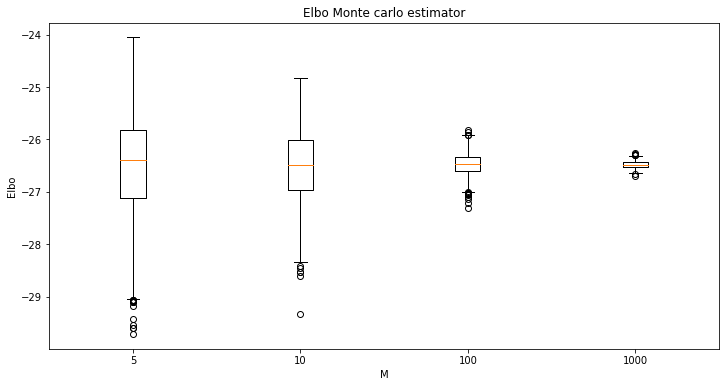

,Mean,Std
5,-26.512032,0.972152
10,-26.527069,0.693759
100,-26.470345,0.211621
1000,-26.480234,0.064192


In [8]:
mu_u = torch.tensor(5.0)
sigma_u = torch.tensor(0.5)
mu_v = torch.tensor(1.)
sigma_v = torch.tensor(0.2)

Ms = [5, 10, 100, 1000]
estimators = torch.zeros((len(Ms), 2))
iterations = 1000
labels = []

fig, ax = plt.subplots()
for idx, M in enumerate(Ms):
    elbo_estimates = torch.zeros((iterations))
    for i in range(iterations):
        q_u = torch.distributions.Normal(mu_u, sigma_u)
        q_v = torch.distributions.Normal(mu_v, sigma_v)
        elbo_estimates[i] = elbo_monte_carlo_estimate(x, p_u, p_v, q_u, q_v, M)
    
    ax.boxplot(elbo_estimates, positions=[idx+1])
    estimators[idx] = torch.tensor([torch.mean(elbo_estimates), torch.std(elbo_estimates)])
    
ax.set_xticklabels(Ms)
ax.set_xlabel('M')
ax.set_ylabel('Elbo')
ax.set_title('Elbo Monte carlo estimator')
#plt.plot(np.arange(0, iterations), elbo_estimates.detach())
plt.show()

df_1 = pd.DataFrame(estimators.detach().numpy(), columns=['Mean', 'Std'], index=Ms)
display(df_1)

By incrementing the number of M samples to estimate the ELBO loss, we see that the uncertainty present in the estimation decrease a lot. Indeed by having a higher number of samples, $M >= 100$ we have a standard deviation of 0.21 or lower as reported in the table. 
This behaviour is expected due to the CLT and the Monte Carlo method.

## Score function estimator

To approximate the ELBO we use the score function estimator, in order to derive the gradient respect to the parameter of the latent distribution.

$$ \begin{aligned}
\frac{d\mathcal{L}}{\mu_u} = \frac{1}{M} \sum_{m=1}^{M} w_m \frac{d\;log\; q(u_m \vert \mu_u, \sigma_u) } {\mu_u}, 
\quad \frac{d\mathcal{L}}{\sigma_u} = \frac{1}{M} \sum_{m=1}^{M} w_m \frac{d\;log\; q(u_m \vert \mu_u, \sigma_u) } {\sigma_u}
\end{aligned}$$


$$ \begin{aligned} \frac{d\;log\; q(u_m \vert \mu_u, \sigma_u) } {\mu_u}
&=  \frac{d} {d\mu_u} \left( -\frac{1}{2} log(2\pi) - log(\sigma_u) - \frac{1}{2} \frac{(u - \mu_u)^2}{\sigma_u^2}\right) \\
&= \frac{d} {d\mu_u} \left( -\frac{1}{2} \frac{u^2 - 2 u \mu_u + \mu^2 }{\sigma_u^2} \right) \\
&= \frac{u - \mu_u}{\sigma_u^2}
\end{aligned}$$

$$ \begin{aligned}
\frac{d\;log\; q(u_m \vert \mu_u, \sigma_u) } {\sigma_u} 
&=  \frac{d} {d\sigma_u} \left( -\frac{1}{2} log(2\pi) - log(\sigma_u) - \frac{1}{2} \frac{(u_m - \mu_u)^2}{\sigma_u^2}\right) \\
&= -\frac{1}{\sigma_u} + \frac{(u_m - \mu_u)^2}{\sigma_u^3}
\end{aligned}$$

Instead by derivating with respect of $\mu_v$ and $\sigma_v$ we obtain:

$$ \begin{aligned} \frac{d\;log\; q(v_m \vert \mu_v, \sigma_v) } {\mu_v} = \frac{v_m - \mu_v}{\sigma_v^2} \\
\frac{d\;log\; q(v_m \vert \mu_v, \sigma_v) } {\sigma_v} = -\frac{1}{\sigma_v} + \frac{(v_m - \mu_v)^2}{\sigma_v^3}
\end{aligned}$$


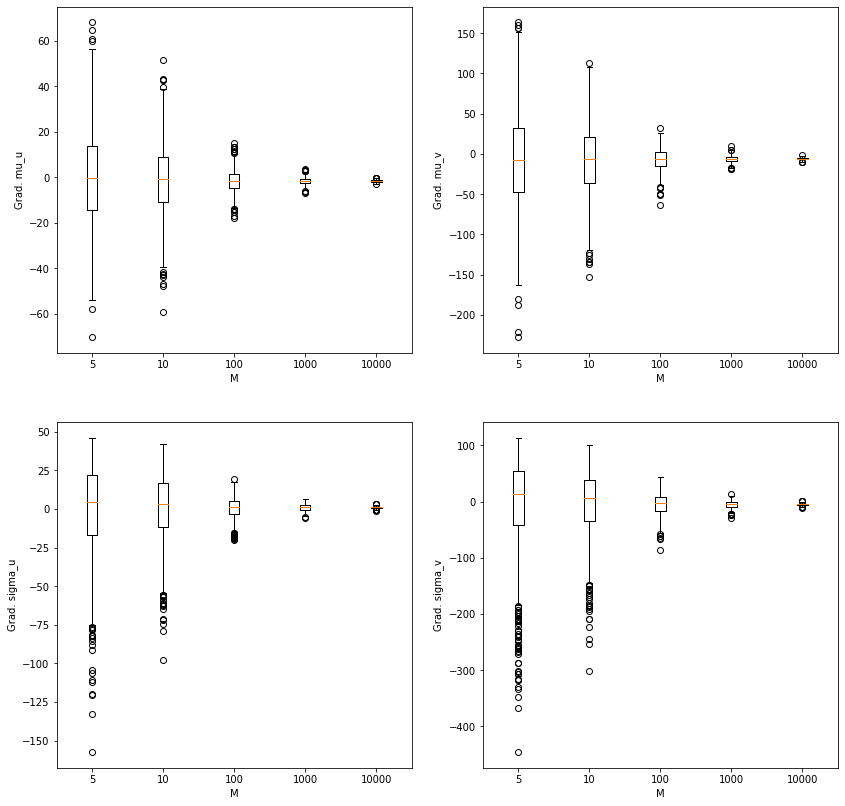

,mean(mu_u),std(mu_u),mean(sigma_u),std(sigma_u),mean(mu_v),std(mu_v),mean(sigma_v),std(sigma_v)
5,-0.608226,-0.046710,21.673779,29.751953,-7.807530,-5.489329,58.587475,85.624237
10,-0.949554,0.542743,15.242384,21.205585,-7.957016,-4.868949,42.808838,58.020103
100,-1.475331,0.945068,4.894294,6.556266,-6.364966,-4.540037,12.726068,18.983078
1000,-1.535130,1.047379,1.524547,2.128790,-6.102365,-4.805733,4.014715,5.955010
10000,-1.532365,1.151927,0.473429,0.667827,-6.026528,-4.664625,1.274959,1.887627


In [11]:
mu_u = torch.tensor(5.0)
sigma_u = torch.tensor(0.5)
mu_v = torch.tensor(1.)
sigma_v = torch.tensor(0.2)

Ms = [5, 10, 100, 1000, 10000]
n_epochs = 1000
estimators = torch.zeros((len(Ms), 8))
fig, ax = plt.subplots(2, 2, figsize=(14, 14))
for idx, M in enumerate(Ms):
    
    u_grad_elbo = torch.zeros((n_epochs, 2))
    v_grad_elbo = torch.zeros((n_epochs, 2))

    for epoch in range(n_epochs):
        q_u = torch.distributions.Normal(mu_u, sigma_u)
        q_v = torch.distributions.Normal(mu_v, sigma_v)
        
        q_u_samples = q_u.sample((M, 1))
        negatives = (q_u_samples < 0.).nonzero()
        # Check if there are negative samples, and resample them. Negative samples are quite rare but they can happen
        while len(negatives) != 0:
            for i in negatives:
                q_u_samples[i[0]] = q_u.sample()
            negatives = (q_u_samples < 0.).nonzero()

        q_v_samples = q_v.sample((M, 1))
        negatives = (q_v_samples < 0.).nonzero()
        # Check if there are negative samples, and resample them. Negative samples are quite rare but they can happen
        while len(negatives) != 0:
            for i in negatives:
                q_v_samples[i[0]] = q_v.sample()
            negatives = (q_v_samples < 0.).nonzero()
        
        W = torch.zeros((M, 1))
        for j in range(0, M):
            likelihood = torch.distributions.Poisson(q_u_samples[j]*q_v_samples[j]) 
            W[j] = torch.sum(likelihood.log_prob(x))
        
        W = W - q_u.log_prob(q_u_samples) - q_v.log_prob(q_v_samples)
        
        ###### u Update
        grad_mu_u = (q_u_samples - mu_u) / (sigma_u**2)
        grad_sigma_u = (q_u_samples - mu_u)**2 / (sigma_u**3) - 1 /sigma_u
        u_mu_elbo_grad = (1/M * torch.matmul(grad_mu_u.T, W))
        u_sigma_elbo_grad = (1/M * torch.matmul(grad_sigma_u.T, W))
        u_grad_elbo[epoch, ] = torch.tensor([u_mu_elbo_grad.item(), u_sigma_elbo_grad.item()])
        
        ###### v Update
        grad_mu_v = (q_v_samples - mu_v) / (sigma_v**2)
        grad_sigma_v = (q_v_samples - mu_v)**2 / (sigma_v**3) - 1 /sigma_v
        v_mu_elbo_grad = (1/M * torch.matmul(grad_mu_v.T, W))
        v_sigma_elbo_grad = (1/M * torch.matmul(grad_sigma_v.T, W))
        v_grad_elbo[epoch, ] = torch.tensor([v_mu_elbo_grad.item(), v_sigma_elbo_grad.item()])
    
    
    ax[0, 0].boxplot(u_grad_elbo[:, 0], positions=[idx+1])
    ax[1, 0].boxplot(u_grad_elbo[:, 1], positions=[idx+1])

    ax[0, 1].boxplot(v_grad_elbo[:, 0], positions=[idx+1])
    ax[1, 1].boxplot(v_grad_elbo[:, 1], positions=[idx+1])

    estimators[idx, :2] = u_grad_elbo.mean(axis=0)
    estimators[idx, 2:4] = u_grad_elbo.std(axis=0)
    estimators[idx, 4:6] = v_grad_elbo.mean(axis=0)
    estimators[idx, 6:] = v_grad_elbo.std(axis=0)

for a in ax.flatten():
    a.set_xticklabels(Ms)
    a.set_xlabel('M')

ax[0, 0].set_ylabel('Grad. mu_u')
ax[1, 0].set_ylabel('Grad. sigma_u')

ax[0, 1].set_ylabel('Grad. mu_v')
ax[1, 1].set_ylabel('Grad. sigma_v')
plt.show()

df = pd.DataFrame(estimators.detach().numpy(), columns=['mean(mu_u)', 'std(mu_u)', 'mean(sigma_u)',  'std(sigma_u)',\
                                                        'mean(mu_v)', 'std(mu_v)', 'mean(sigma_v)', 'std(sigma_v)'], index=Ms)
display(df)

As we see in the previous results, the score function estimator algorithm requires very large M for reducing the variance in the estimation. With few number of samples during the Monte carlo approximation we have a variance for $\sigma_u$ and $\sigma_v$ of the order of 20 or more, the same but with a lower uncertainty happen with $mu_v$.
By increasing the number of samples up to 10000 we are able to achieve low variance values as shown in table and in the boxplot.
A better solution in order to reduce the variance in the algorithm would be to use the control variates, which hasn't been implemented in this homework.

## Reparameterization gradient estimator 

Having:

$$ z \sim \mathcal{N(0,1)}, \quad f(z, \mu, \sigma) = \mu + \sigma z$$

The gradient of the elbo using the reparameterization trick can be approximated as following:
$$
\begin{aligned}
\nabla_{\mathbf{\lambda}} \mathcal{L} &\approx \frac{1}{M} \sum_{m} \nabla_{\mathbf{\lambda}} log\;p (\mathbf{x},f(\mathbf{z}_m, \mathbf{\lambda})) -  \nabla_{\mathbf{\lambda}} log\;q (f(\mathbf{z}_m, \mathbf{\lambda}), \mathbf{\lambda}) \\ 
&\approx \frac{1}{M} \sum_{m} \nabla_{\mathbf{\theta}} log\;p (\mathbf{x}, u, v) \nabla_{\mathbf{\lambda}} f (\mathbf{z}_m, \mathbf{\lambda}) - \nabla_{\mathbf{\lambda}} log\;q (f(\mathbf{z}_m, \mathbf{\lambda}), \mathbf{\lambda})
\end{aligned}
$$

The derivaties required are:

$$
\frac{d\log p(\mathbf{x},u,v)}{du} = \sum_i \left [\frac{x_i}{u} - v \right ] + \frac{(\alpha_u -1)}{u} - \beta_u 
$$ 
$$
\frac{d\log p(\mathbf{x},u,v)}{dv} = \sum_i \left [\frac{x_i}{v} - u \right ] + \frac{(\alpha_v -1)}{v} - \beta_v
$$

$$
\frac{d\;log\; q(f_u \vert \mu_u, \sigma_u) } {u} = \frac{\mu_u - f_u}{\sigma_u^2}
$$

$$
\frac{d\;log\; q(f_v \vert \mu_v, \sigma_v) } {v} = \frac{\mu_v - f_v}{\sigma_v^2}
$$

$$
\frac{d\; f(z, \mu, \sigma)} {\mu} = \frac{d}{\mu}(\mu + \sigma z) = 1
$$

$$
\frac{d\; f(z, \mu, \sigma)} {\sigma} = \frac{d}{\sigma}(\mu + \sigma z) = z
$$


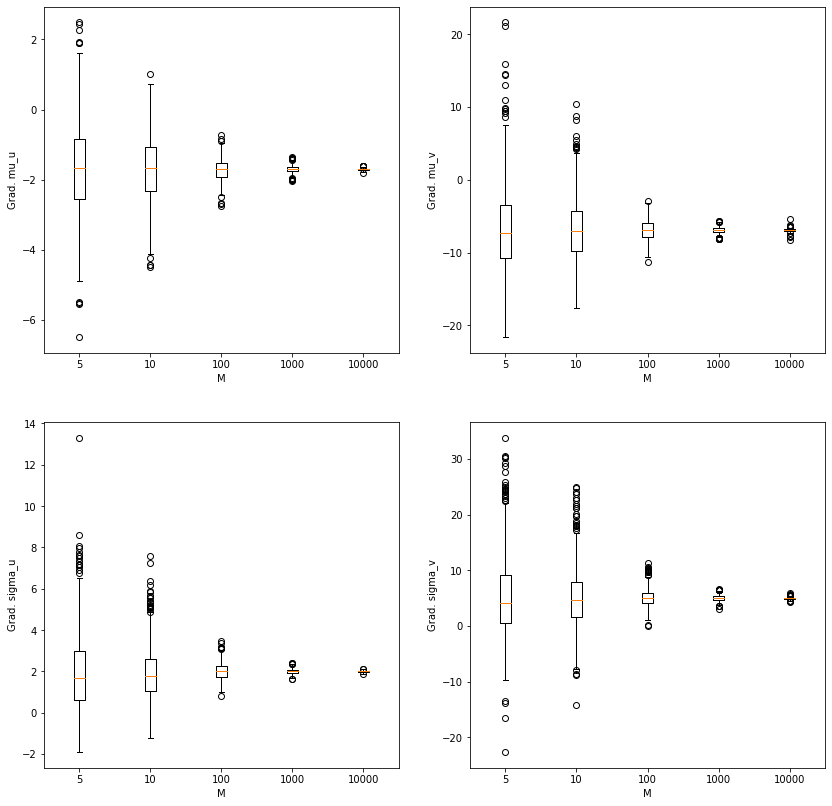

,mean(mu_u),std(mu_u),mean(sigma_u),std(sigma_u),mean(mu_v),std(mu_v),mean(sigma_v),std(sigma_v)
5,-1.663140,1.975147,1.289329,1.768136,-6.895297,5.131171,5.789169,6.940351
10,-1.691376,1.913365,0.917489,1.211992,-6.895947,5.003443,4.133027,5.061472
100,-1.705581,2.008330,0.288077,0.402485,-6.907227,5.050674,1.312126,1.600204
1000,-1.701394,1.999444,0.098073,0.125644,-6.885194,4.981885,0.414891,0.522787
10000,-1.704538,1.997240,0.029467,0.039287,-6.914496,4.996222,0.155592,0.165576


In [4]:
from pandas._libs.algos import diff_2d
mu_u = torch.tensor(5.0)
sigma_u = torch.tensor(0.5)
mu_v = torch.tensor(1.)
sigma_v = torch.tensor(0.2)

Ms = [5, 10, 100, 1000, 10000]
n_epochs = 1000
estimators_r = torch.zeros((len(Ms), 8))
fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for idx, M in enumerate(Ms):
    u_grad_elbo_2 = torch.zeros((n_epochs, 2))
    v_grad_elbo_2 = torch.zeros((n_epochs, 2))
    for epoch in range(n_epochs):
        z_dist = torch.distributions.Normal(0, 1)
        z = z_dist.sample((M, 1))
        z_2 = z_dist.sample((M, 1))


        q_u = torch.distributions.Normal(mu_u, sigma_u)  
        q_u_samples = q_u.sample((M, 1))
        
        q_v = torch.distributions.Normal(mu_v, sigma_v)
        q_v_samples = q_v.sample((M, 1))

        grad_mu_u = 0
        grad_sigma_u = 0

        grad_mu_v = 0
        grad_sigma_v = 0
        for i in range(0, M):
            ## Gradient u
            grad_log_p_u = torch.sum(x/q_u_samples[i] - q_v_samples[i]) + (prior_u_alpha - 1)/ q_u_samples[i] - prior_u_beta
            f_u_z = mu_u + sigma_u * z[i]
            grad_log_q_f_u = (mu_u - f_u_z)/ sigma_u**2
            #### mu 
            grad_mu_u += grad_log_p_u * 1. - grad_log_q_f_u * 1.

            #### sigma
            grad_f_u_sigma = z[i]
            grad_sigma_u += grad_log_p_u * grad_f_u_sigma - grad_log_q_f_u * grad_f_u_sigma
            
            ## Gradient v
            grad_log_p_v = torch.sum(x/q_v_samples[i] - q_u_samples[i]) + (prior_v_alpha - 1)/ q_v_samples[i] - prior_v_beta
            f_v_z = mu_v + sigma_v * z_2[i]
            grad_log_q_f_v = (mu_v - f_v_z)/ sigma_v**2
            #### mu 
            grad_mu_v += grad_log_p_v * 1. - grad_log_q_f_v * 1.

            #### sigma
            grad_f_v_sigma = z_2[i]
            grad_sigma_v += grad_log_p_v * grad_f_v_sigma - grad_log_q_f_v * grad_f_v_sigma
        
        u_grad_elbo_2[epoch] = torch.tensor([grad_mu_u, grad_sigma_u]) / M
        v_grad_elbo_2[epoch] = torch.tensor([grad_mu_v, grad_sigma_v]) / M

    ax[0, 0].boxplot(u_grad_elbo_2[:, 0], positions=[idx+1])
    ax[1, 0].boxplot(u_grad_elbo_2[:, 1], positions=[idx+1])

    ax[0, 1].boxplot(v_grad_elbo_2[:, 0], positions=[idx+1])
    ax[1, 1].boxplot(v_grad_elbo_2[:, 1], positions=[idx+1])

    estimators_r[idx, :2] = u_grad_elbo_2.mean(axis=0)
    estimators_r[idx, 2:4] = u_grad_elbo_2.std(axis=0)
    estimators_r[idx, 4:6] = v_grad_elbo_2.mean(axis=0)
    estimators_r[idx, 6:] = v_grad_elbo_2.std(axis=0)

for a in ax.flatten():
    a.set_xticklabels(Ms)
    a.set_xlabel('M')

ax[0, 0].set_ylabel('Grad. mu_u')
ax[1, 0].set_ylabel('Grad. sigma_u')

ax[0, 1].set_ylabel('Grad. mu_v')
ax[1, 1].set_ylabel('Grad. sigma_v')
plt.show()

df_2 = pd.DataFrame(estimators_r.detach().numpy(), columns=['mean(mu_u)', 'std(mu_u)', 'mean(sigma_u)',  'std(sigma_u)',\
                                                        'mean(mu_v)', 'std(mu_v)', 'mean(sigma_v)', 'std(sigma_v)'], index=Ms)
display(df_2)
    


Using the reparameterization trick we see that even with 5 samples as starting point the uncertainty present in the algorithm is lower respect to the score estimator approach. By incrementing the number of samples we see get a more certain values of the gradient, thus we reduce the variance.

### Comparing the results 

As shown below both algorithms achieve approximately the same results, but the reparameterization gradient estimator method is more sample efficient and less computational expensive than the other method.
Indeed the score estimator method requires 100 times more samples to achieve the same resuls of the reparameterization gradient, as we can see from the table below.

The sign of the gradient of the parameters for the optimum score estimator, i.e when M=10000, are all negative except of $\sigma_u$. Indeed by comparing with the previous solutions of the Poisson-Gramma distribution we see that achieved value and sign of the gradient are all coherent. In fact the direction of the achieved negative gradient values are negative, thus toward the true values ($\mu_u = 4.65, \mu_v = 0.911$ ), which are lower than the initial ones.
The same result is also achieved by the parameterization gradient method.

The only discrepancy between the two algorithms in this experiment regards the gradient estimation of $\sigma_v$. Indeed the latter one has a positive sign instead the former one present a negative negative sign, but they're absolute values approximately the same. I also tried to debug the code and implement the reparameterization method using the automatic differentiation of pytorch, but It achieve the negative value, for this reason I let the analytical differentiation solution.

In [13]:
print('Score function estimator')
display(df)
print()
print('Reparametrization gradient estimator')
display(df_2)

Score function estimator


,mean(mu_u),std(mu_u),mean(sigma_u),std(sigma_u),mean(mu_v),std(mu_v),mean(sigma_v),std(sigma_v)
5,-0.608226,-0.046710,21.673779,29.751953,-7.807530,-5.489329,58.587475,85.624237
10,-0.949554,0.542743,15.242384,21.205585,-7.957016,-4.868949,42.808838,58.020103
100,-1.475331,0.945068,4.894294,6.556266,-6.364966,-4.540037,12.726068,18.983078
1000,-1.535130,1.047379,1.524547,2.128790,-6.102365,-4.805733,4.014715,5.955010
10000,-1.532365,1.151927,0.473429,0.667827,-6.026528,-4.664625,1.274959,1.887627



Reparametrization gradient estimator


,mean(mu_u),std(mu_u),mean(sigma_u),std(sigma_u),mean(mu_v),std(mu_v),mean(sigma_v),std(sigma_v)
5,-1.663140,1.975147,1.289329,1.768136,-6.895297,5.131171,5.789169,6.940351
10,-1.691376,1.913365,0.917489,1.211992,-6.895947,5.003443,4.133027,5.061472
100,-1.705581,2.008330,0.288077,0.402485,-6.907227,5.050674,1.312126,1.600204
1000,-1.701394,1.999444,0.098073,0.125644,-6.885194,4.981885,0.414891,0.522787
10000,-1.704538,1.997240,0.029467,0.039287,-6.914496,4.996222,0.155592,0.165576


# Problem 2: VAE

The code snippets below implement a VAE for MNIST digits and some visualizations for the results. Check the pdf for instructions of what do to.

## Model definition and optimization

**(a)**
We want to learn the probability distribution of the data (in our case MNIS dataset), call it $p(\mathbf{x})$. A way to approximate this distribution is by parametrized it and marginalize the joint probability with some latent variable $\mathbf{z}$ having, $p_{\theta}(\mathbf{z})$ as prior distribution. Thus we have:

$$ p_\theta(\mathbf{x}) = \int_z p_{\theta}(\mathbf{x}, \mathbf{z }) d\mathbf{z} = \int_z p_{\theta}(\mathbf{x} \vert \mathbf{z }) p_{\theta}(\mathbf{z }) d\mathbf{z}$$

Assuming that the likelihood is a Gaussian distribution and the prior a mixture of a Guassian (in our example a Standard Normal distribution) allows us to have a closed form solution.

Having said that we can use the Bayes to infer the posterior latent distribution $p_\theta (\mathbf{z} \vert \mathbf{x})$,  such samples from this distribution  are likely later to give $x_i$.
$$p_\theta (\mathbf{z} \vert \mathbf{x}) = \frac{p_{\theta}(\mathbf{x} \vert \mathbf{z }) p_{\theta}(\mathbf{z})}{p_\theta(\mathbf{x})} $$

Unluckily, this is very computational demanding as the  integral of $p_\theta(\mathbf{x})$ is untractable. </br>
For this reason it is necessary to introduce an approximated distribution $q_\Phi (\mathbf{z} \vert \mathbf{x}) \approx p_\theta (\mathbf{z} \vert \mathbf{x})$. The $q_\Phi$ distribution can be chosen as Normal distribution where $\Phi = (\mathbf{\mu}, \mathbf{\sigma})$ as parameter.

In order to achieve the desired approximation the problem can be model as an optimization, where the goal is to find a $\Phi$ of $q_\Phi (\mathbf{z} \vert \mathbf{x})$ that approximate the true posterior distribution $p_\theta (\mathbf{z} \vert \mathbf{x})$. To obtain this result a very useful function, coming from information theory, is the Kullback-Leibler divergence which can measure how $q_\Phi (\mathbf{z} \vert \mathbf{x})$ is different than $p_\theta (\mathbf{z} \vert \mathbf{x})$, and is defined as:
$$\mathbf{KL}(q_\Phi (\mathbf{z} \vert \mathbf{x}) \; \vert\vert \;p_\theta (\mathbf{z} \vert \mathbf{x})) = \mathbf{E}_q[log \; q_\Phi (\mathbf{z} \vert \mathbf{x})] - \mathbf{E}_q[log \; p_{\theta} (\mathbf{z} \vert \mathbf{x})] + log\; p_\theta(\mathbf{x}).$$

By minimizing this function we could find the optimum parameters of $\Phi$ that solve our problem. Sadly as we in the last term involve the $p_\theta(\mathbf{x})$ which is untractable.

For this reason we use an approximation technique called variational inference,
where the minimization of the KL divergence can be alternatively re-write as maximinzing a lower bound for the marginal likelihood. Thus we have:
$$ log \; p_\theta(\mathbf{x}) = \mathbf{E}_{q}[log \; p_\theta(\mathbf{x},\mathbf{z})] - \mathbf{E}_q[log \; q_{\Phi}(\mathbf{z} \vert \mathbf{x})] + \mathbf{KL}(q_\Phi (\mathbf{z} \vert \mathbf{x})\; \vert\vert \;p_\theta (\mathbf{z} \vert \mathbf{x})).$$

By applying the Jensen’s inequality, the Kullback-Leibler divergence is always greater than or equal to zero. This means that minimizing the Kullback-Leibler divergence is equivalent to maximizing the first two terms which defines the ELBO (Evidence Lower BOund) function, which allows us to do approximate posterior inference.
$$ \mathcal{L}_{ELBO} = \mathbf{E}_{q}[log \; p_\theta(\mathbf{x},\mathbf{z})] -\mathbf{KL}(q_\Phi (\mathbf{z} \vert \mathbf{x})\; \vert\vert \;p_\theta (\mathbf{z}))$$
$$ \Phi^* = argmax_\Phi \;\mathcal{L}_{ELBO} $$

We can now maximize the ELBO using the stochastic gradient descent, but in order to compute the gradient of the ELBO we require one more step, the reparameterization trick. Indeed by defining
$$\mathbf{z} = \mu + \sigma \; \mathcal{N}(0,1)$$
We can easily compute the gradient of the ELBO using Monte Carlo method to approximate the expected value.

Finally by defining a probabilistic neural network with encoder and decoder architecture using  the ELBO function with the parametrization trick to compute the gradient and exploit the backgpopagation the neural network,  we are able by maximizing the ELBO to approximate the probability distribution of the data.
Indeed the architecture of the network can be defined as followed:
 * $\mathbf{x}$ represent the data in input
 * $\mathbf{z}  \sim q_\Phi({z \vert x}) = \mathcal{N}(\mathbf{\mu},\mathbf{\sigma})$  can be described as an encoder network, which has a funnel shape architecture of neural layers to describe the latent variable, and  it uses non linear function (e.g relu) after each layer.
 * $\mathbf{z} = \mathbf{\mu} + \mathbf{\sigma} \odot \mathcal{\epsilon}, \quad \mathcal{\epsilon} \sim \mathcal{N}(0, \mathbf{I})$ where $(\mathbf{\mu},\mathbf{\sigma})$ are the latent variables present after the last layer of the encoder. Notice that the $\sigma$ parameter is retrieve by applying a sigmoid function after the relu function in the last layer to have a positive parameter between 0 and 1. From the latent variable, which is described by the $q_\Phi({z \vert x})$ Normla distribution, finally we sample $\mathbf{z}$ from the distribution and pass it to the decoder to reconstruct it. 
 * $p_\theta(\mathbf{x} \vert \mathbf{z})$ represent the decoder with $\theta$ as the weights of the decoder network. The last layer of the decoder has to have the same dimension of the input layer, in order to reconstruct the real data.
 * The neural network present two encoders, one for the latent variable $\mathbf{\mu}$ and the other for $\mathbf{\sigma}$, both made by 10 variables/neurons each. Each encoder has 2 layers of 20 neurons and the final latent variable of 10 neurons.
 * After sampling from a multivariate normal given by $\mu$ and $\sigma$ which come from the encoder, we pass the samples to the decoder, which has the objective to reconstruct the image, using a decoder which follow the same architecture of the encoder but in the reverse order.
 * The loss function that the neural network minimize is the **negative** $\mathcal{L}_{ELBO}$, since we want convert the optimization as a minimization problem using the backpropagation to estimate the gradient and we do the gradient step to update $\mu$ and $\sigma$ and the other weights of the neural network 

In [ ]:
def vae_elbo_dkl_loss(x_mean, obs_sigma, mu, sigma, q_z_x, p_z, x):
    logp_x_z = torch.sum(torch.distributions.Normal(x_mean, obs_sigma).log_prob(x), 1)
    KL = torch.sum(q_z_x.log_prob(z) - p_z.log_prob(z), 1)
    loss = - torch.mean(logp_x_z - KL, 0)
    return loss

def vae_elbo_jsd_loss(x_mean, obs_sigma, mu, sigma, q_z_x, p_z, x):
    logp_x_z = torch.sum(torch.distributions.Normal(x_mean, obs_sigma).log_prob(x), 1)
    p_mu = 0.5 * mu 
    p_var = 0.25 * (sigma + 1)
    t_z = torch.distributions.Normal(p_mu, p_var)

    KLD_1 = torch.sum(q_z_x.log_prob(z) - t_z.log_prob(z), 1)
    KLD_2 = torch.sum(p_z.log_prob(z) - t_z.log_prob(z), 1)
    JKLD = 0.5 * (KLD_1 + KLD_2)
    #KLD_1 = torch.sum(0.5 * (torch.log(p_var) - torch.log(sigma) +  (sigma + (mu - p_mu).pow(2)) / (p_var) - 1))
    #KLD_2 = torch.sum(0.5 * (torch.log(p_var) + (1 + p_mu.pow(2))/p_var  - 1))

    loss = - torch.mean(logp_x_z - JKLD, 0)
    return loss

In [ ]:
import torch
import torch.nn as nn
import torchvision
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Set hyperparameters of the model and optimization
K = 5
obs_sigma = 0.1
batch_size = 50
# You will want to use a bigger number, but I set it small by default
# so that it is faster to run the code for the first time. Increasing
# numEpoch does not yet count as proper modification.
numEpoch = 5   
lr = 0.001

# MNIST data 
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=batch_size, shuffle=True)

# Prior distribution for latent variables
p_z = torch.distributions.Normal(0., 1.)

# Encoder and decoder specifications
D = 28*28
H = 20
encoder_mu = nn.Sequential(nn.Linear(D,H), nn.ReLU(),
                           nn.Linear(H,H), nn.ReLU(),
                           nn.Linear(H,K,bias=True))
encoder_sigma = nn.Sequential(nn.Linear(D,H), nn.ReLU(),
                              nn.Linear(H,H), nn.ReLU(),
                              nn.Linear(H,K,bias=True))
decoder = nn.Sequential(nn.Linear(K,H), nn.ReLU(),
                        nn.Linear(H,H), nn.ReLU(),
                        nn.Linear(H,D,bias=True))

# Optimize over parameters of all networks
params = list(encoder_mu.parameters()) + list(encoder_sigma.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=lr)

elbos = []
loss = None
for i in tqdm(range(numEpoch)):
    batches = iter(train_loader)

    epochloss = 0.
    for j in range(len(batches)):
        optimizer.zero_grad()

        # Next batch of samples
        batch_data, batch_targets = next(batches)
        x = batch_data.reshape((batch_size,-1))
    
        # Form parameters of approximation
        mu = encoder_mu(x)
        unconstrained_sigma = encoder_sigma(x)
        sigma = torch.sigmoid(unconstrained_sigma)
        
        # Sample from approximation
        # - rsample() handles reparameterization internally,
        #   so we do not need to do it manually
        # - Note that sample() would not work correctly
        q_z_x = torch.distributions.Normal(mu, sigma)
        z = q_z_x.rsample()

        # Find mean parameters of observed data
        x_mean = decoder(z)
    
        loss = vae_elbo_dkl_loss(x_mean, obs_sigma, mu, sigma, q_z_x, p_z, x)

        epochloss += loss
    
        loss.backward()
        optimizer.step()
    elbos.append(-epochloss/len(batches))

  0%|          | 0/5 [00:00<?, ?it/s]

**(b)**
In the recent years it has been tried to improved some of the issues that regards VAE. An example can be the KL vanishing issue, which is found when the KL term becomes vanishingly small that could cause the latent variable to be almost identical to the Guassian priori for all the observed data, and the decoder to ignore the latent features. To solve this problem it has been proposed the cyclical annealing schedule (Bowman, et al), that add a new hyperparameter $\beta$ in front of the DKL term.
Thus, by starting with a small coefficient $\beta$, we put more weights on reconstructing term. As Beta increases during the trianing, the model gradually emphasizes the KL divergence loss, until reaching the pre-specified value of $\beta$.

$$ \mathcal{L}_{ELBO} = \mathbf{E}_{q}[log \; p_\theta(\mathbf{x},\mathbf{z})] -\beta \; \mathbf{KL}(q_\Phi (\mathbf{z} \vert \mathbf{x})\; \vert\vert \;p_\theta (\mathbf{z}))$$

Algthough this approach could be helpful in many in case, in our experiment we didn't suffer from this problem. 
For this reason we focused on a more recent paper, called "Constraining Variational Inference with Geometric Jensen-Shannon Divergence" by Jacob Deasy et.al (2020), which applies a regularization method on the latent space, in the optimization problem during the training of the VAE. In their work proposes an alternative divergence measure called Jensen-Shannon Divergence, a  which is defined as:
$$ JSD_\alpha (q \vert\vert p) = ( (1 - \alpha ) \; D_{KL} (q \;\vert\vert \; t) + \alpha \; D_{KL} (p \;\vert\vert \; t)), \quad  t = \alpha(q + p) $$
Thus, by using this new measure in our problem, as suggested in the equation 22 of the paper and assuming $\alpha=0.5$, we end up defining the following new loss function. 
$$\begin{aligned}
\mathcal{L}_{ELBO-JSD} &= \mathbf{E}_{q}[log \; p_\theta(\mathbf{x},\mathbf{z})] -\beta \; JSD_{\alpha=0.5}(q_\Phi (\mathbf{z} \vert \mathbf{x})\; \vert\vert \;p_\theta (\mathbf{z}))
\end{aligned}$$

Thanks to this metric we exploits the symmetry in loss function, when $\alpha=0.5$ and it results still in a closed form solution for the optimization problem. In addition they concluded this alternative of VAE has shown better  reconstructions than other baselines and they believe that it adds regularisation mechanism to address the trade-off between zero-avoidance and zero-forcing in latent space.

In [ ]:
encoder_mu_jsd = nn.Sequential(nn.Linear(D,H), nn.ReLU(),
                           nn.Linear(H,H), nn.ReLU(),
                           nn.Linear(H,K,bias=True))
encoder_sigma_jsd = nn.Sequential(nn.Linear(D,H), nn.ReLU(),
                              nn.Linear(H,H), nn.ReLU(),
                              nn.Linear(H,K,bias=True))
decoder_jsd = nn.Sequential(nn.Linear(K,H), nn.ReLU(),
                        nn.Linear(H,H), nn.ReLU(),
                        nn.Linear(H,D,bias=True))

# Optimize over parameters of all networks
params = list(encoder_mu_jsd.parameters()) + list(encoder_sigma_jsd.parameters()) + list(decoder_jsd.parameters())
optimizer = torch.optim.Adam(params, lr=lr)

# Prior distribution for latent variables
p_z = torch.distributions.Normal(0., 1.)

elbos_jsd = []
numEpoch = 5
loss = None
for i in tqdm(range(numEpoch)):
    batches = iter(train_loader)

    epochloss = 0.
    for j in range(len(batches)):
        optimizer.zero_grad()

        # Next batch of samples
        batch_data, batch_targets = next(batches)
        x = batch_data.reshape((batch_size,-1))
    
        # Form parameters of approximation
        mu = encoder_mu_jsd(x)
        unconstrained_sigma = encoder_sigma_jsd(x)
        sigma = torch.sigmoid(unconstrained_sigma)
        
        # Sample from approximation
        # - rsample() handles reparameterization internally,
        #   so we do not need to do it manually
        # - Note that sample() would not work correctly
        q_z_x = torch.distributions.Normal(mu, sigma)
        z = q_z_x.rsample()

        # Find mean parameters of observed data
        x_mean_jsd = decoder(z)
        
        loss_2 = vae_elbo_jsd_loss(x_mean_jsd, obs_sigma, mu, sigma, q_z_x, p_z, x)
        epochloss += loss_2
    
        loss_2.backward()
        optimizer.step()
    elbos_jsd.append(-epochloss/len(batches))


  0%|          | 0/5 [00:00<?, ?it/s]

## Plotting functionality

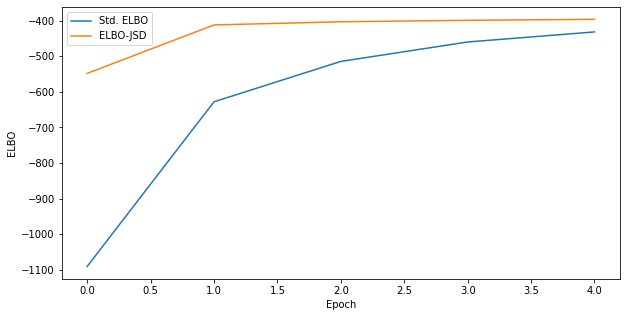

In [ ]:
plt.rcParams["figure.figsize"] = (10, 5)
plt.plot(torch.tensor(elbos).detach(), label='Std. ELBO')
plt.plot(torch.tensor(elbos_jsd).detach(), label='ELBO-JSD')
plt.legend()
plt.xlabel('Epoch')
_ = plt.ylabel('ELBO')

In the previous figure we show the ELBO loss values for both VAEs. 
We clearly see that the alternative VAE using JSD divergence achieve better local minima during the optimization problem in less epoch than the Standard method using DKL. Thus we can conclude that the Symmetric divergence improved the results of the VAE by achieving a better optimum solution.

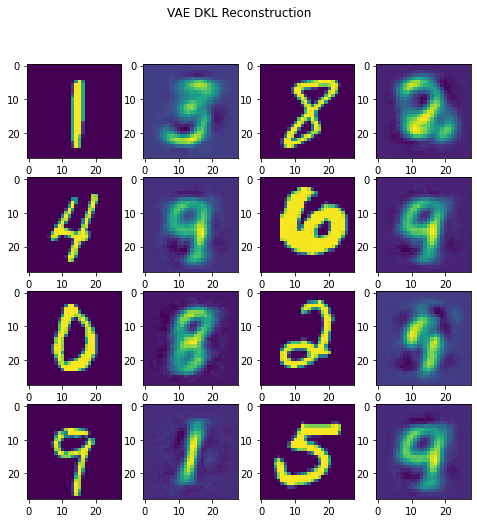

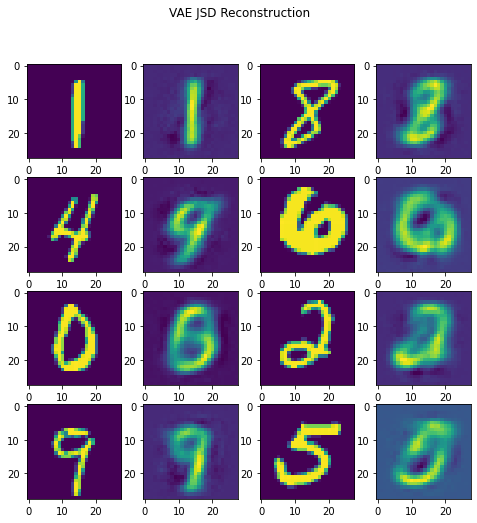

In [ ]:
plt.rcParams["figure.figsize"] = (8, 8)
# Note: Uses the values from the last iteration of the algorithm
for sam in range(8):
    plt.subplot(4,4,sam*2+1)
    plt.imshow(x[sam,:].reshape(28,28))

    plt.subplot(4,4,sam*2+2)
    plt.imshow(x_mean[sam,:].detach().reshape(28,28))

figure = plt.gcf()
figure.suptitle('VAE DKL Reconstruction ')
plt.show()
print()

# Note: Uses the values from the last iteration of the algorithm
for sam in range(8):
    plt.subplot(4,4,sam*2+1)
    plt.imshow(x[sam,:].reshape(28,28))

    plt.subplot(4,4,sam*2+2)
    plt.imshow(x_mean_jsd[sam,:].detach().reshape(28,28))
    
figure = plt.gcf()
figure.suptitle('VAE JSD Reconstruction ')
plt.show()

From the above plot we can see the reconstruction of some training imagesretrieved from the decoder after sampling from the latent map.<br/>
We see that the VAE is able to find some latent variables which can describe pretty well the data, indeed the decoder is able to almost reconstruct the given sample. <br/>
Some of them can be slighlty different from the ground thruth but we see that those results are also plausible since they are similar to the true label. For example a 3 can be very close to 9 or 8; 1 with 7, and so on so forth. Indeed these similar numbers are going to be close to each other in the manifold of the latent distribution. 

From both figure we see that the VAE with JSD divergence achieve better results during the reconstruction for the chosen samples. Although both results are in accordance to the expected ones. Another way to improve the latent distribution for the first VAE would be to increase the epochs in order to gain maximize more the elbo and gain more accuracy. 

Text(0.5, 1.0, 'VAE ELBO - JSD')

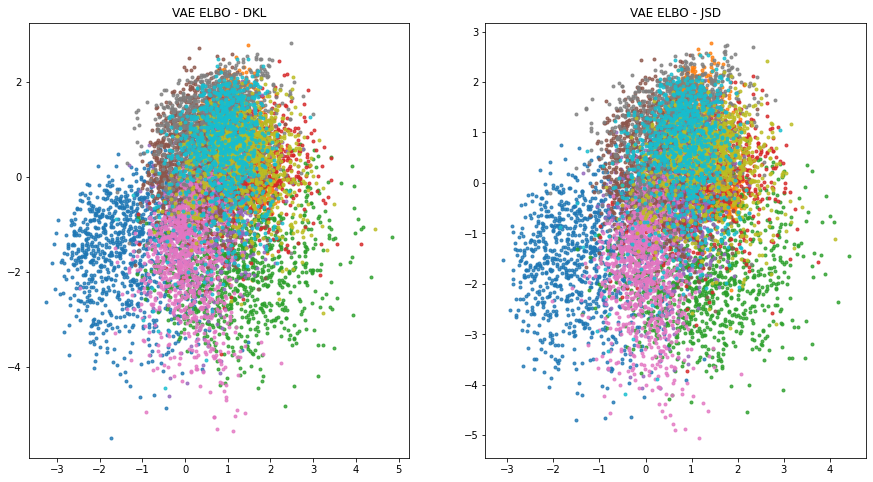

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=10000, shuffle=True)

batches = iter(train_loader)
batch_data, batch_targets = next(batches)
x = batch_data.reshape((10000,-1))

mu = encoder_mu(x)
unconstrained_sigma = encoder_sigma(x)

mu_jsd = encoder_mu_jsd(x)
unconstrained_sigma_jsd = encoder_sigma_jsd(x)

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
for c in range(10):
    _ = axes[0].plot(mu.detach()[batch_targets==c,0], mu.detach()[batch_targets==c,1], '.', alpha=0.8)
    _ = axes[1].plot(mu_jsd.detach()[batch_targets==c,0], mu_jsd.detach()[batch_targets==c,1], '.', alpha=0.8)
axes[0].set_title('VAE ELBO - DKL')
axes[1].set_title('VAE ELBO - JSD')

In this figure instead we see the values of the $\mu$ latent variable by sampling 10000 data point from the training set. We plot the first two dimension of the $\mu$ latent variable in order to visualize it in 2 dimensional space. 

The figure represents the mapped values of the given data, and we see that the VAE is able to form some clusterized representation of the 10 digits. Indeed this confirm the fact that same and similar digits are represented in closed locations of the manifold. 

Finally, we can say that both VAE are able to obtain promising results.